In [1]:
from timbr import Snapshot
#data = Snapshot("/Users/chelm/.timbr/data/shopify_cities_100k")
#data = Snapshot("/Users/chelm/.timbr/data/shopify_cities_50k")
data = Snapshot("/Users/chelm/.timbr/data/shopify_9_cities") # 10k

In [4]:
from string import Template
import json, time
from IPython.display import HTML
from IPython.core.display import display_html, display_javascript, Javascript
import datetime
from dateutil import parser

def renderChord( rows, cities=None ):
    # Rows with to and from cities
    if cities is None:
        cities = list(set([row['to_city'] for row in rows]))
        
    cityRows = []
    for row in rows:
        if 'to_city' in row and 'from_city' in row:
            if row['to_city'] in cities and row['from_city'] in cities:
                cityRows.append(row)

    html = """<h2>Chord Diagram of Shopify Orders</h2><div id="chord-chart"></div>"""
    d3js = Template("""

    var data = $data;
    
    var outerRadius = 560 / 2,
        innerRadius = outerRadius - 65;

    var fill = d3.scale.category20();
    var fill = d3.scale.ordinal()
        .range(["#a6cee3","#1f78b4","#b2df8a","#33a02c","#fb9a99","#e31a1c","#fdbf6f","#ff7f00","#cab2d6"])

    var chord = d3.layout.chord()
        .padding(.04)
        .sortSubgroups(d3.descending)
        .sortChords(d3.descending);

    var arc = d3.svg.arc()
        .innerRadius(innerRadius)
        .outerRadius(innerRadius + 20);

    var svg = d3.select("#chord-chart").append("svg")
        .attr("width", outerRadius * 3)
        .attr("height", outerRadius * 3)
      .append("g")
        .attr("transform", "translate(" + (outerRadius + 50) + "," + (outerRadius + 10) + ")");

      var indexByName = d3.map(),
          nameByIndex = d3.map(),
          matrix = [],
          n = 0;

      // Compute a unique index for each package name.
      data.forEach(function(d) {
        if (!indexByName.has(d = d.from_city)) {
          nameByIndex.set(n, d);
          indexByName.set(d, n++);
        }
      });

      // Construct a square matrix counting package imports.
      data.forEach(function(d) {
        var source = indexByName.get(d.from_city),
            row = matrix[source];
        if (!row) {
         row = matrix[source] = [];
         for (var i = -1; ++i < n;) row[i] = 0;
        }
        data.forEach(function(d) { row[indexByName.get(d.to_city)]++; });
      });

      chord.matrix(matrix);
  
      var g = svg.selectAll(".group")
          .data(chord.groups)
        .enter().append("g")
          .attr("class", "group");
    
      g.append("path")
          .style("fill", function(d) { return fill(d.index); })
          .style("stroke", function(d) { return fill(d.index); })
          .attr("d", arc)
          .attr("id", function(d) { return "path-" + d.index })
          .on("mouseover", fade(.1))
          .on("mouseout", fade(1));
          

      g.append("text")
          .each(function(d) { d.angle = (d.startAngle + d.endAngle) / 2; })
          .attr("dy", ".35em")
          .attr("transform", function(d) {
            return "rotate(" + (d.angle * 180 / Math.PI - 90) + ")"
                + "translate(" + (innerRadius + 26) + ")"
                + (d.angle > Math.PI ? "rotate(180)" : "");
          })
          .style("text-anchor", function(d) { return d.angle > Math.PI ? "end" : null; })
          .text(function(d) { return nameByIndex.get(d.index); });
      
      svg.selectAll(".chord")
          .data(chord.chords)
        .enter().append("path")
          .attr("class", "chord")
          .style("stroke", function(d) { return d3.rgb(fill(d.source.index)).darker(); })
          .style("fill", function(d) { return fill(d.source.index); })
          .attr("d", d3.svg.chord().radius(innerRadius))
    
      // Returns an event handler for fading a given chord group.
      function fade(opacity) {
        return function(g, i) {
          svg.selectAll(".chord")
              .filter(function(d) { return d.source.index != i && d.target.index != i; })
            .transition()
              .style("opacity", opacity);
        };
      }
    
    """)

    js_libs = ['https://cdnjs.cloudflare.com/ajax/libs/d3/3.5.6/d3.min.js']
    display_javascript( Javascript(data='', lib=js_libs))

    time.sleep(1)

    def renderd3(html, js, libs=[]):   
        display_html(HTML(data=html))
        display_javascript( Javascript(data=js, lib=libs))  

    d3js = d3js.substitute({"data": json.dumps(cityRows)});
    renderd3(html, d3js)
    
uids, rows = zip(*data)
renderChord(rows)
#renderChord(rows, ['Chicago', 'Miami', 'Boston', 'Denver', 'Seattle'])


Chord Diagram of Shopify Orders

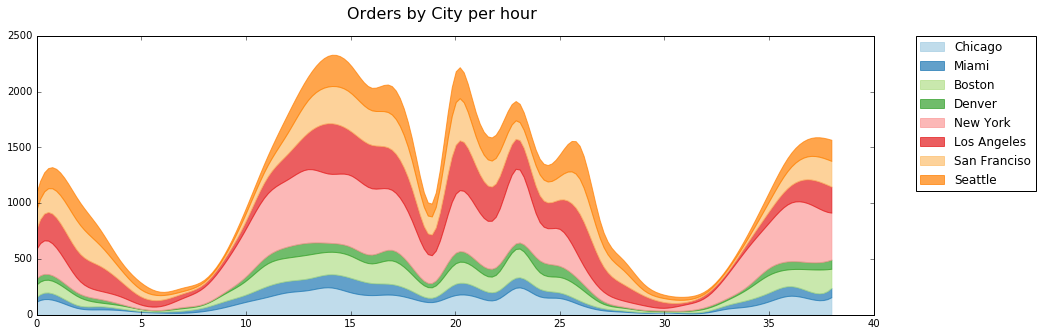

In [25]:
%matplotlib inline
import datetime
from dateutil import parser
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import spline

def roundTime(dt=None, dateDelta=datetime.timedelta(minutes=3)):
    roundTo = dateDelta.total_seconds()
    if dt == None : dt = datetime.datetime.now()
    seconds = (dt - dt.min).seconds
    # // is a floor division, not a comment on following line:
    rounding = (seconds+roundTo/2) // roundTo * roundTo
    return dt + datetime.timedelta(0,rounding-seconds,-dt.microsecond)

def streamGraph( rows, var='to_city', cities=None):
    delta = datetime.timedelta(hours=1)
    if cities is None:
        cities = list(set([row[var] for row in rows]))        
    
    fig = plt.figure()
    fig.set_size_inches(15, 5)
    fig.suptitle('Orders by City per hour', fontsize=16)
    ax1 = fig.add_subplot(111)
    
    times = sorted(list(set([roundTime( parser.parse(row['created_at']), delta) for i, row in data ])))
    minT = min(times) 
    maxT = max(times)
    diff = maxT - minT
    
    buckets = [[0]*(len(cities)+1) for i in range(int(diff.total_seconds() / 60 / 60) + 1)]
    
    for i, row in data:
        time = roundTime( parser.parse(row['created_at']), delta )
        t_idx = times.index(time)
    
        try:
            city_idx = cities.index(row[var]) + 1 or None
            if city_idx is not None:
                buckets[t_idx][city_idx] += 1
        except:
            pass
    
        try:
            buckets[t_idx][0] += 1
        except:
            print t_idx

    def smooth(x, y):
        x_sm = np.array(x)
        y_sm = np.array(y)
        x_smooth = np.linspace(x_sm.min(), x_sm.max(), 200)
        y_smooth = spline(x, y, x_smooth)
        return x_smooth, y_smooth
    

    colors = ["#a6cee3","#1f78b4","#b2df8a","#33a02c","#fb9a99","#e31a1c","#fdbf6f","#ff7f00","#cab2d6"]
    n = range(len(buckets))
    
    for i, city in enumerate(cities):
        x, line = smooth(n, [b[i+1] for b in buckets])
        
        if i == 0: 
            y1 = line
            y0 = line     
            ax1.fill_between(x, 0, y1, color=colors[i], alpha=.7, label=city)
        else:
            y1 = map(sum, zip(y1, line))
            ax1.fill_between(x, y0, y1, color=colors[i], alpha=.7, label=city)
            y0 = y1
                      
 
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()
    

uids, rows = zip( *data )

streamGraph( rows )
#streamGraph( rows, cities=['New York', 'Los Angeles', 'Chicago', 'Seattle'])

    